<a href="https://colab.research.google.com/github/yashwardhan-gautam/Grid2.0/blob/master/VoiceFilter.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Mount drive

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


### Basic necessary definitions

#### Hyper Parameters

In [2]:
class HyperParams:
  n_fft= 1200
  num_freq= 601 # n_fft//2 + 1
  sample_rate= 16000
  hop_length= 160
  win_length= 400
  min_level_db= -100.0
  ref_level_db= 20.0
  preemphasis= 0.97
  power= 0.30
  embedder_window= 80
  data_audio_len= 3.0
  embedder_num_mels= 40
  embedder_lstm_hidden = 768
  embedder_emb_dim = 256
  embedder_lstm_layers = 3
  embedder_window = 80
  embedder_stride = 40
  model_lstm_dim = 400
  model_fc1_dim = 600
  model_fc2_dim = 601 # num_freq

#### Audio related helper functions

In [3]:
import librosa
import numpy as np  

In [4]:
class Audio:
  def __init__(self,hyper_params):
    self.hyper_params = hyper_params
    self.mel_basis_matrix = librosa.filters.mel(sr=hyper_params.sample_rate,
                                             n_fft=hyper_params.n_fft,
                                             n_mels=hyper_params.embedder_num_mels);

  def get_mel_spec(self,wave):
    spec = librosa.core.stft(y=wave, n_fft=self.hyper_params.n_fft,
                              hop_length=self.hyper_params.hop_length,
                              win_length=self.hyper_params.win_length,
                              window='hann')
    power_spec = np.abs(spec) ** 2
    mel_spec = np.log10(np.dot(self.mel_basis_matrix,power_spec)+1e-6)
    return mel_spec  
  def wave2spec(self,wave): 
    spec = librosa.core.stft(y=wave, n_fft=self.hyper_params.n_fft,
                            hop_length=self.hyper_params.hop_length,
                            win_length=self.hyper_params.win_length)
    phase = np.angle(spec)
    spec_db = self.amp2db(np.abs(spec))
    spec_db_norm = self.normalize(spec_db)
    spec_db_norm = spec_db_norm.T   # Taking transpose here
    phase = phase.T # Taking transpose here
    return spec_db_norm, phase
  def spec2wave(self,spec_db_norm,phase):
    spec_db_norm, phase = spec_db_norm.T, phase.T
    spec_db = self.denormalize(spec_db_norm)
    spec_amp = self.db2amp(spec_db)
    spec = spec_amp * np.exp(1j*phase)
    wave = librosa.core.istft(spec,
                             hop_length=self.hyper_params.hop_length,
                             win_length=self.hyper_params.win_length)
    return wave
  def amp2db(self,mat):
    return 20.0 * np.log10(np.maximum(1e-5,mat)) - self.hyper_params.ref_level_db
  def db2amp(self,mat):
    return np.power(10.0, (mat+self.hyper_params.ref_level_db)*0.05)
  def normalize(self,mat):
    return np.clip((mat-self.hyper_params.min_level_db)/-self.hyper_params.min_level_db, 0.0 , 1.0)
  def denormalize(self, mat):
    return np.clip(mat,0.0,1.0)*(-self.hyper_params.min_level_db)+self.hyper_params.min_level_db

In [5]:
hyper_params = HyperParams()
audio = Audio(hyper_params)

#### Define paths and create folders

In [6]:
import os

In [7]:
dataset_path = os.path.join('drive','My Drive','LibriSpeech Dataset');
path = {}
path['dev'] = os.path.join(dataset_path,'LibriSpeech Dev Dataset')
path['test'] = os.path.join(dataset_path,'LibriSpeech Test Dataset')
path['train'] = os.path.join(dataset_path ,'LibriSpeech Train Dataset')

In [ ]:
# create directories to store dataset
for dataset in ('dev','test','train'):
  os.makedirs(os.path.join(path[dataset],'input_spec'),exist_ok=True)
  os.makedirs(os.path.join(path[dataset],'output_spec'),exist_ok=True)
  os.makedirs(os.path.join(path[dataset],'input_phase'),exist_ok=True)
  os.makedirs(os.path.join(path[dataset],'output_phase'),exist_ok=True)
  os.makedirs(os.path.join(path[dataset],'dvector'),exist_ok=True)

In [ ]:
# create 8 separate directories for training dataset to avoid issues with gdrive
def create_folders(i):
  os.makedirs(os.path.join(path['train'],'input_spec_'+i),exist_ok=True)
  os.makedirs(os.path.join(path['train'],'output_spec_'+i),exist_ok=True)
  os.makedirs(os.path.join(path['train'],'input_phase_'+i),exist_ok=True)
  os.makedirs(os.path.join(path['train'],'output_phase_'+i),exist_ok=True)
  os.makedirs(os.path.join(path['train'],'dvector_'+i),exist_ok=True)

In [ ]:
for i in range(8):
  create_folders(str(i))

### Unzip LibriSpeech dataset ( Execute just once )

In [ ]:
import shutil

In [ ]:
shutil.unpack_archive('drive/My Drive/LibriSpeech Dataset/dev-clean.tar.gz','drive/My Drive/LibriSpeech Dataset/')
# Rename the extracted folder LibriSpeech to LibriSpeech Dev Dataset

In [ ]:
shutil.unpack_archive('drive/My Drive/LibriSpeech Dataset/test-clean.tar.gz','drive/My Drive/LibriSpeech Dataset/')
# Rename the extracted folder LibriSpeech to LibriSpeech Test Dataset

In [ ]:
shutil.unpack_archive('drive/My Drive/LibriSpeech Dataset/train-clean-100.tar.gz','drive/My Drive/LibriSpeech Dataset/')
# Rename the extracted folder LibriSpeech to LibriSpeech Train Dataset

### Create and store speech collection

In [15]:
import glob
import pickle

In [ ]:
#### Run this cell only the first time ####
dev_base_path = os.path.join(path['dev'],'dev-clean')
test_base_path = os.path.join(path['test'],'test-clean')
train_base_path = os.path.join(path['train'],'train-clean-100')

In [ ]:
#### Run this cell only the first time ####
dev_spks = os.listdir(dev_base_path)
# list of all speaker folders
dev_speeches = [glob.glob(os.path.join(dev_base_path,spk,'*','*.flac'),recursive=True) for spk in dev_spks]
dev_speeches = [speeches for speeches in dev_speeches if len(speeches)>=2]
# list of lists containing speeches of a speaker
test_spks = os.listdir(test_base_path)
# list of all speaker folders
test_speeches = [glob.glob(os.path.join(test_base_path,spk,'*','*.flac'),recursive=True) for spk in test_spks]
test_speeches = [speeches for speeches in test_speeches if len(speeches)>=2]
# list of lists containing speeches of a speaker
train_spks = os.listdir(train_base_path)
# list of all speaker folders
train_speeches = [glob.glob(os.path.join(train_base_path,spk,'*','*.flac'),recursive=True) for spk in train_spks]
train_speeches = [speeches for speeches in train_speeches if len(speeches)>=2]
# list of lists containing speeches of a speaker

In [ ]:
##### Run this cell only the first time #####
with open(os.path.join(path['dev'],'dev_speeches.data'),'wb') as f:
  pickle.dump(dev_speeches,f)
with open(os.path.join(path['test'],'test_speeches.data'),'wb') as f:
  pickle.dump(test_speeches,f)
with open(os.path.join(path['train'],'train_speeches.data'),'wb') as f:
  pickle.dump(train_speeches,f)

In [16]:
with open(os.path.join(path['dev'],'dev_speeches.data'),'rb') as f:
  dev_speeches = pickle.load(f)
with open(os.path.join(path['test'],'test_speeches.data'),'rb') as f:
  test_speeches = pickle.load(f)
with open(os.path.join(path['train'],'train_speeches.data'),'rb') as f:
  train_speeches = pickle.load(f)

### Use pre trained model to obtain Embedding

In [ ]:
import torch
import torch.nn as nn

class LinearNorm(nn.Module):
    def __init__(self, hp):
        super(LinearNorm, self).__init__()
        self.linear_layer = nn.Linear(hp.embedder_lstm_hidden, hp.embedder_emb_dim)

    def forward(self, x):
        return self.linear_layer(x)


class SpeechEmbedder(nn.Module):
    def __init__(self, hp):
        super(SpeechEmbedder, self).__init__()
        self.lstm = nn.LSTM(hp.embedder_num_mels,
                            hp.embedder_lstm_hidden,
                            num_layers=hp.embedder_lstm_layers,
                            batch_first=True)
        self.proj = LinearNorm(hp)
        self.hp = hp

    def forward(self, mel):
        # (num_mels, T)
        mels = mel.unfold(1, self.hp.embedder_window, self.hp.embedder_stride) # (num_mels, T', window)
        mels = mels.permute(1, 2, 0) # (T', window, num_mels)
        x, _ = self.lstm(mels) # (T', window, lstm_hidden)
        x = x[:, -1, :] # (T', lstm_hidden), use last frame only
        x = self.proj(x) # (T', emb_dim)
        x = x / torch.norm(x, p=2, dim=1, keepdim=True) # (T', emb_dim)
        x = x.sum(0) / x.size(0) # (emb_dim), average pooling over time frames
        return x

In [ ]:
embedder_path = os.path.join(dataset_path,"embedder.pt")
embedder_pt = torch.load(embedder_path,map_location=torch.device('cpu'))
embedder = SpeechEmbedder(hyper_params)
embedder.load_state_dict(embedder_pt)
embedder.eval()

SpeechEmbedder(
  (lstm): LSTM(40, 768, num_layers=3, batch_first=True)
  (proj): LinearNorm(
    (linear_layer): Linear(in_features=768, out_features=256, bias=True)
  )
)

### Prepare dataset

In [ ]:
import random
import pandas as pd

In [ ]:
# returns dvec for the input wave using pre trained embedder model
def get_dvector(wave):
  mel_spec = audio.get_mel_spec(wave)
  dvec = embedder(torch.from_numpy(mel_spec).float())
  dvec = dvec.detach().numpy()
  return dvec

In [ ]:
# pre process waves and store spectrogram, phase and dvector in their respective folders
def create_example(target_dir, hyper_params, idx, ref_speech, pri_speech, sec_speech):
  sample_rate = hyper_params.sample_rate
  ref_wave, _ = librosa.load(ref_speech,sr=sample_rate) #load the audio file
  pri_wave, _ = librosa.load(pri_speech, sr = sample_rate)
  sec_wave,_ = librosa.load(sec_speech, sr = sample_rate)
  assert len(ref_wave.shape)==len(pri_wave.shape)==len(sec_wave.shape)==1,\
  'wave files must be mono and not stereo'
  ref_wave,_ = librosa.effects.trim(ref_wave, top_db = 20) # clip silent portion on both ends
  pri_wave,_ = librosa.effects.trim(pri_wave, top_db = 20)
  sec_wave,_ = librosa.effects.trim(sec_wave, top_db = 20)
  
  if ref_wave.shape[0] < 1.1 * hyper_params.embedder_window * hyper_params.hop_length :
    return
  length_wave = int(sample_rate * hyper_params.data_audio_len)
  if pri_wave.shape[0]<length_wave or sec_wave.shape[0]<length_wave:
    return
  pri_wave, sec_wave = pri_wave[:length_wave], sec_wave[:length_wave] # clip wave to fixed length
  mix_wave = pri_wave + sec_wave
  norm = np.max(np.abs(mix_wave)) * 1.1
  pri_wave, mix_wave = pri_wave/norm , mix_wave/norm  # normalize wave by 1.1*max(absolute amplitude)
  pri_spec, pri_phase = audio.wave2spec(pri_wave)  # convert wave to spec
  mix_spec, mix_phase = audio.wave2spec(mix_wave)
  dvec = get_dvector(ref_wave)

  # paths for storing data
  pri_spec_path = os.path.join(target_dir,'output_spec','%06d.npy'%idx)
  pri_phase_path = os.path.join(target_dir,'output_phase','%06d.npy'%idx)
  mix_spec_path = os.path.join(target_dir, 'input_spec','%06d.npy'%idx)
  mix_phase_path = os.path.join(target_dir,'input_phase','%06d.npy'%idx)
  dvec_path = os.path.join(target_dir,'dvec','%06d.npy'%idx)
  # store data on paths above
  np.save(pri_spec_path,pri_spec)
  np.save(mix_spec_path,mix_spec)
  np.save(mix_phase_path, mix_phase)
  np.save(pri_phase_path, pri_phase)
  np.save(dvec_path,dvec)

  #print(idx)
  return [idx, ref_speech, pri_speech, sec_speech,  mix_spec_path, pri_spec_path, mix_phase_path, pri_phase_path, dvec_path]

In [ ]:
columns=['key','ref_speech','pri_speech','sec_speech','input_spec_path','output_spec_path','input_phase_path','output_phase_path','dvector_path']

In [ ]:
#### to be run just once ####
sample_data_frame = pd.DataFrame(data = [], columns=columns)
for dataset in ('train','dev','test'):
  sample_data_frame.to_csv(os.path.join(path[dataset],'data_frame.csv'),index=False);

In [ ]:
def create_dataset(i):
  batch = []
  array = range(i+1,n+1)
  if parity == 1:
    array = range(1,i)
  for j in array:
    first = min(i,j)
    sec = max(i,j)
    if (sec-first)%2 == parity:
      first, sec = sec, first
    n1 = len(speeches[first-1]) # -1 accounts for zero based indexing
    n2 = len(speeches[sec-1]) # -1 accounts for zero based indexing
    sum = first+sec-1 # -1 accounts for zero based indexing
    diff = first-sec-1 # -1 accounts for zero based indexing
    diff_mod = (abs(diff))%n1
    if diff < 0 and diff_mod > 0:
      diff_mod = n1 - diff_mod
    ref_speech = speeches[first-1][diff_mod]
    pri_speech = speeches[first-1][sum%n1]
    sec_speech = speeches[sec-1][first%n2]
    row = create_example( path[dataset], hyper_params , n*(i-1) + j, ref_speech, pri_speech, sec_speech)
    if row is not None:
      batch.append(row)
  print(i)
  return batch

In [ ]:
def save_batch(dataset,data):
  df_path = os.path.join(path[dataset],'data_frame.csv')
  df = pd.read_csv(df_path)
  df_batch = pd.DataFrame(data = data, columns = columns)
  df = df.append(df_batch)
  df.to_csv(df_path,index=False)

In [ ]:
import os
import time
from multiprocessing import Pool
cpu_num = len(os.sched_getaffinity(0))

In [ ]:
print("Number of cpu available : ",cpu_num)

2

#### Dev set

In [ ]:
dataset = 'dev' # important global variable
speeches = dev_speeches # important global variable
n = len(dev_speeches) # important global variable
print("number of speakers(dev set) : ",n)
for i in range(n):
  random.shuffle(dev_speeches[i])  # shuffle the speeches of all speakers
arr = list(range(1,n+1))  # create a list for all speakers

number of speakers(dev set) :  40


In [ ]:
data = []
parity = 0 # important global variable
x = time.time()
with Pool(cpu_num) as p:
  res = p.map(create_dataset, arr , 4)
for batch in res:
  if len(batch) > 0:
    data.extend(batch)
y = time.time()
print(y-x)
save_batch('dev',data)

In [ ]:
data = []
parity = 1 # important global variable
x = time.time()
with Pool(cpu_num) as p:
  res = p.map(create_dataset, arr , 4)
for batch in res:
  if len(batch) > 0:
    data.extend(batch)
y = time.time()
print(y-x)
save_batch('dev',data)

#### Test set

In [ ]:
dataset = 'test' # important global variable
speeches = test_speeches # important global variable
n = len(test_speeches) # important global variable
print("number of speakers(test set) : ",n)
for i in range(n):
  random.shuffle(test_speeches[i])  # shuffle the speeches of all speakers
arr = list(range(1,n+1))  # create a list for all speakers

number of speakers(test set) :  40


In [ ]:
data = []
parity = 0 # important global variable
x = time.time()
with Pool(cpu_num) as p:
  res = p.map(create_dataset, arr , 4)
for batch in res:
  if len(batch) > 0:
    data.extend(batch)
y = time.time()
print(y-x)
save_batch('test',data)

In [ ]:
data = []
parity = 1 # important global variable
x = time.time()
with Pool(cpu_num) as p:
  res = p.map(create_dataset, arr , 4)
for batch in res:
  if len(batch) > 0:
    data.extend(batch)
y = time.time()
print(y-x)
save_batch('test',data)

#### Train set

In [ ]:
dataset = 'train' # important global variable
speeches = train_speeches # important global variable
n = len(train_speeches) # important global variable
print("number of speakers(train set) : ",n)
for i in range(n):
  random.shuffle(train_speeches[i])  # shuffle the speeches of all speakers
arr = list(range(1,n+1))  # create a list for all speakers

number of speakers(train set) :  251


##### 0-100

In [ ]:
data = []
parity = 0 # important global variable
x = time.time()
with Pool(cpu_num) as p:
  res = p.map(create_dataset, arr[0:25] , 4)
for batch in res:
  if len(batch) > 0:
    data.extend(batch)
y = time.time()
print(y-x)
save_batch('train',data)

In [ ]:
data = []
parity = 0 # important global variable
x = time.time()
with Pool(cpu_num) as p:
  res = p.map(create_dataset, arr[25:50] , 4)
for batch in res:
  if len(batch) > 0:
    data.extend(batch)
y = time.time()
print(y-x)
save_batch('train',data)

In [ ]:
data = []
parity = 0 # important global variable
x = time.time()
with Pool(cpu_num) as p:
  res = p.map(create_dataset, arr[50:75] , 4)
for batch in res:
  if len(batch) > 0:
    data.extend(batch)
y = time.time()
print(y-x)
save_batch('train',data)

In [ ]:
data = []
parity = 0 # important global variable
x = time.time()
with Pool(cpu_num) as p:
  res = p.map(create_dataset, arr[75:100] , 4)
for batch in res:
  if len(batch) > 0:
    data.extend(batch)
y = time.time()
print(y-x)
save_batch('train',data)

In [ ]:
data = []
parity = 0 # important global variable
x = time.time()
with Pool(cpu_num) as p:
  res = p.map(create_dataset, arr[75:100] , 4)
for batch in res:
  if len(batch) > 0:
    data.extend(batch)
y = time.time()
print(y-x)
save_batch('train',data)

##### 100-200

In [ ]:
data = []
parity = 0 # important global variable
x = time.time()
with Pool(cpu_num) as p:
  res = p.map(create_dataset, arr[100:125] , 4)
for batch in res:
  if len(batch) > 0:
    data.extend(batch)
y = time.time()
print(y-x)
save_batch('train',data)

In [ ]:
data = []
parity = 0 # important global variable
x = time.time()
with Pool(cpu_num) as p:
  res = p.map(create_dataset, arr[125:150] , 4)
for batch in res:
  if len(batch) > 0:
    data.extend(batch)
y = time.time()
print(y-x)
save_batch('train',data)

In [ ]:
data = []
parity = 0 # important global variable
x = time.time()
with Pool(cpu_num) as p:
  res = p.map(create_dataset, arr[150:175] , 4)
for batch in res:
  if len(batch) > 0:
    data.extend(batch)
y = time.time()
print(y-x)
save_batch('train',data)

In [ ]:
data = []
parity = 0 # important global variable
x = time.time()
with Pool(cpu_num) as p:
  res = p.map(create_dataset, arr[175:200] , 4)
for batch in res:
  if len(batch) > 0:
    data.extend(batch)
y = time.time()
print(y-x)
save_batch('train',data)

##### 200-251

In [ ]:
data = []
parity = 0 # important global variable
x = time.time()
with Pool(cpu_num) as p:
  res = p.map(create_dataset, arr[200:225] , 4)
for batch in res:
  if len(batch) > 0:
    data.extend(batch)
y = time.time()
print(y-x)
save_batch('train',data)

In [ ]:
data = []
parity = 0 # important global variable
x = time.time()
with Pool(cpu_num) as p:
  res = p.map(create_dataset, arr[225:251] , 4)
for batch in res:
  if len(batch) > 0:
    data.extend(batch)
y = time.time()
print(y-x)
save_batch('train',data)

#### Grouping data to avoid gdrive timeout

In [ ]:
import shutil
import os
import pandas as pd

In [ ]:
# move files in the dataframe from start_index to end_index to folder for fraction j
def move_files(start_index,end_index,j):
  df_train = pd.read_csv(os.path.join(path['train'],'data_frame.csv'))
  for i in range(start_index,end_index):
    for col in ['dvector_path','input_phase_path','input_spec_path','output_phase_path','output_spec_path']:
      old_path = df_train[col][i]
      new_path = os.path.join(path['train'],col.rsplit('_',1)[0]+"_"+str(j),old_path.split('/')[-1])
      #print(old_path,"  ",new_path)
      shutil.move(old_path,new_path)
      df_train.loc[i,col]=new_path  
  df_train.to_csv(os.path.join(path['train'],'data_frame.csv'),index=False)

In [ ]:
num_fractions = 8
fraction_sizes = num_fractions * [ num_samples//num_fractions ]
for i in range(num_samples%num_fractions):
  fraction_sizes[i]+=1
print(fraction_sizes)

In [ ]:
start_pos = 0
for i in range(num_fractions):
  end_pos = start_pos + fraction_sizes[i]
  move_files(start_pos,end_pos,i)
  start_pos = end_pos

### Data Analysis

In [8]:
import pandas as pd

In [70]:
def print_stats(dataset):
  df = pd.read_csv(os.path.join(path[dataset],'data_frame.csv'))
  num_samples = df.shape[0]
  cnt=0 # cnt of the number of times primary speech is same as the reference speech
  pairs = {} # cnt of all ordered pairs of speakers
  waves=[]
  for i in range(num_samples):
    ref = df['ref_speech'][i]
    pri = df['pri_speech'][i]
    sec = df['sec_speech'][i]
    ref_wave = ref.split('/')[-1]
    pri_wave = pri.split('/')[-1]
    sec_wave = sec.split('/')[-1]
    waves.append(ref_wave)
    waves.append(pri_wave)
    waves.append(sec_wave)
    pri_spk = pri.split('/')[-3]
    sec_spk = sec.split('/')[-3]
    if (pri_spk,sec_spk) in pairs:
      pairs[(pri_spk,sec_spk)]+=1
    else :
      pairs[(pri_spk,sec_spk)]=1
    if pri_wave == ref_wave:
      cnt += 1
  waves = len(list(set(waves)))
  if dataset == 'train':
    speeches = train_speeches
  elif dataset == 'dev':
    speeches = dev_speeches
  else :
    speeches = test_speeches
  total_speeches = sum([len(spk) for spk in speeches])
  print("====================",dataset,"dataset statistics ====================")
  print("Total no. of unique speeches available in LibriSpeech",dataset,"dataset :",total_speeches)
  print("No. of unique speeches used :",waves)
  print("Percentage of total speeches used : {:.2f} %".format((waves/total_speeches)*100))
  print("------------------------------------------------------------")
  print("Total no. of samples prepared :",num_samples)
  print("No. of samples with same primary and reference speech :",cnt)
  print("Fraction of such samples as a part of the entire dataset : {:.2f} %".format((cnt/num_samples)*100))
  print("-------------------------------------------------------------")
  if all(val == 1 for val in pairs.values()):
    print("Note: All ordered pairs of primary and secondary speakers are unique")

In [71]:
print_stats('train')

==================== train dataset statistics ====================
Total no. of unique speeches available in LibriSpeech train dataset : 28539
No. of unique speeches used : 26869
Percentage of total speeches used : 94.15 %
------------------------------------------------------------
Total no. of samples prepared : 29351
No. of samples with same primary and reference speech : 376
Fraction of such samples as a part of the entire dataset : 1.28 %
-------------------------------------------------------------
Note: All ordered pairs of primary and secondary speakers are unique


In [72]:
print_stats('dev')

==================== dev dataset statistics ====================
Total no. of unique speeches available in LibriSpeech dev dataset : 2703
No. of unique speeches used : 1878
Percentage of total speeches used : 69.48 %
------------------------------------------------------------
Total no. of samples prepared : 934
No. of samples with same primary and reference speech : 10
Fraction of such samples as a part of the entire dataset : 1.07 %
-------------------------------------------------------------
Note: All ordered pairs of primary and secondary speakers are unique


In [73]:
print_stats('test')

==================== test dataset statistics ====================
Total no. of unique speeches available in LibriSpeech test dataset : 2620
No. of unique speeches used : 1838
Percentage of total speeches used : 70.15 %
------------------------------------------------------------
Total no. of samples prepared : 964
No. of samples with same primary and reference speech : 11
Fraction of such samples as a part of the entire dataset : 1.14 %
-------------------------------------------------------------
Note: All ordered pairs of primary and secondary speakers are unique


### Create Model

In [57]:
#input dims for model [ T_dim, num_freq ]
T_dim = 301 
num_freq =  hyper_params.num_freq
emb_dim = hyper_params.embedder_emb_dim
lstm_dim =  hyper_params.model_lstm_dim
fc1_dim = hyper_params.model_fc1_dim
fc2_dim = hyper_params.model_fc2_dim #num_freq
batch_size = 8

In [58]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import Model
from tensorflow.keras.layers import Multiply, ZeroPadding2D, concatenate, Conv2D, Input, Dense, Reshape, BatchNormalization, Activation, LSTM, Bidirectional, Lambda

In [59]:
def get_model():
  dvec_inp = Input(shape=[emb_dim],name="dvec")
  input_spec = Input(shape=[T_dim,num_freq],name="input_spec")
  x = Reshape((T_dim,num_freq,1))(input_spec)
 
  # cnn
 
  #cnn1
  x = ZeroPadding2D(((0,0), (3,3)))(x)
  x = Conv2D(filters=64, kernel_size=[1,7], dilation_rate=[1, 1])(x)
  x = BatchNormalization()(x)
  x = Activation('relu')(x)
  #cnn2
  x = ZeroPadding2D(((3,3), (0,0)))(x)
  x = Conv2D(filters=64, kernel_size=[7,1], dilation_rate=[1, 1])(x)
  x = BatchNormalization()(x)
  x = Activation('relu')(x)
  #cnn3
  x = ZeroPadding2D(((2,2), (2,2)))(x)
  x = Conv2D(filters=64, kernel_size=[5,5], dilation_rate=[1, 1])(x)
  x = BatchNormalization()(x)
  x = Activation('relu')(x)
  #cnn4
  x = ZeroPadding2D(((4,4), (2,2)))(x)
  x = Conv2D(filters=64, kernel_size=[5,5], dilation_rate=[2, 1])(x)
  x = BatchNormalization()(x)
  x = Activation('relu')(x)
  #cnn5
  x = ZeroPadding2D(((8,8), (2,2)))(x)
  x = Conv2D(filters=64, kernel_size=[5,5], dilation_rate=[4, 1])(x)
  x = BatchNormalization()(x)
  x = Activation('relu')(x)
  #cnn6
  x = ZeroPadding2D(((16,16), (2,2)))(x)
  x = Conv2D(filters=64, kernel_size=[5,5], dilation_rate=[8, 1])(x)
  x = BatchNormalization()(x)
  x = Activation('relu')(x)
  #cnn7
  x = ZeroPadding2D(((32,32), (2,2)))(x)
  x = Conv2D(filters=64, kernel_size=[5,5], dilation_rate=[16, 1])(x)
  x = BatchNormalization()(x)
  x = Activation('relu')(x)
  #cnn8
  x = Conv2D(filters=8, kernel_size=[1,1], dilation_rate=[1, 1])(x)
  x = BatchNormalization()(x)
  x = Activation('relu')(x)
   
  x = Reshape((x.shape[1],x.shape[2]*x.shape[3]))(x) #else use -1 as last arg
  #x = tf.reshape(x, [x.shape[0],x.shape[1],-1])
 
  dvec = Lambda(lambda a : tf.expand_dims(a,1))(dvec_inp)
  dvec = Lambda(lambda a : tf.repeat(a,repeats =x.shape[1],axis =1))(dvec)
  #dvec= tf.expand_dims(dvec_inp,1)
  #dvec= tf.repeat(dvec,repeats =x.shape[1],axis =1)
  
  x = concatenate([x,dvec],-1)
  #x= tf.concat([x,dvec],-1)
  
  #lstm
  x = Bidirectional(LSTM(lstm_dim,return_sequences=True))(x)
  
  #fc1
  x = Dense(fc1_dim,activation ="relu")(x)
  #fc2
  mask = Dense(fc2_dim,activation ="sigmoid",name="mask")(x) #soft mask
  
  #element-wise
  output = Multiply()([input_spec,mask])

  model = Model(inputs=[input_spec,dvec_inp], outputs=output)
 
  return model

In [60]:
model = get_model()
#model_val = get_model()
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_spec (InputLayer)         [(None, 301, 601)]   0                                            
__________________________________________________________________________________________________
reshape (Reshape)               (None, 301, 601, 1)  0           input_spec[0][0]                 
__________________________________________________________________________________________________
zero_padding2d (ZeroPadding2D)  (None, 301, 607, 1)  0           reshape[0][0]                    
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 301, 601, 64) 512         zero_padding2d[0][0]             
______________________________________________________________________________________________

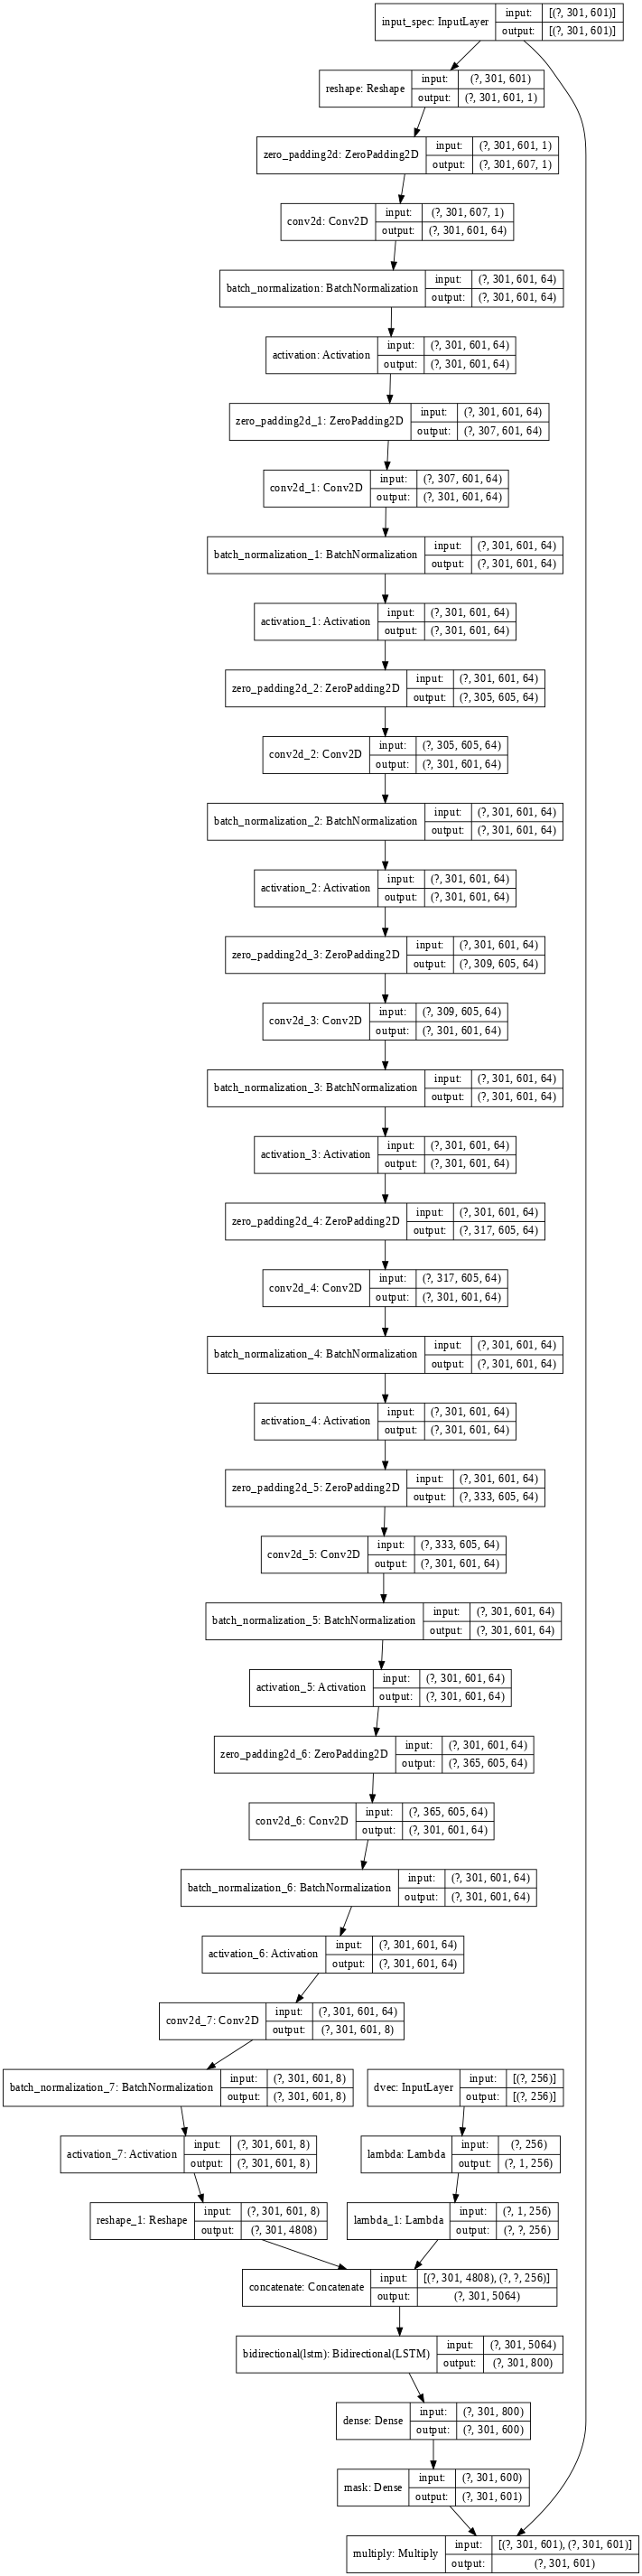

In [61]:
model.compile(optimizer='adam', loss='mse')
tf.keras.utils.plot_model(model, show_shapes=True, dpi=64)

In [ ]:
### execute just once ###
model.save_weights(os.path.join(dataset_path,'Model weights','weights_epoch0000.h5'))

### Load Data and Train


In [ ]:
!pip install mir_eval

In [ ]:
import os
import pandas as pd
import numpy as np
from tensorflow.keras.utils import Sequence

In [ ]:
# loads the numpy arrays whose path is stored in the column "col" of "data_frame"
def load_col_data(data_frame ,indices, start_pos, end_pos, col):
  col_list = []
  for i in range(start_pos,end_pos):
    idx = indices[i]
    col_list.append(np.load(data_frame[col][idx]))
    print(idx)
  return np.array(col_list)

In [ ]:
## preload training data into 8 separate folders to avoid issues with gdrive
def preload_training_data(cur_fraction, start_pos, end_pos):
  input_spec = load_col_data(df_train, list(range(num_samples)) , start_pos , end_pos ,'input_spec_path' )
  np.save(os.path.join(dataset_path,'PreLoad Training Dataset','fraction_'+str(cur_fraction),'input_spec'),input_spec)
  output_spec = load_col_data(df_train, list(range(num_samples)), start_pos, end_pos, 'output_spec_path')
  np.save(os.path.join(dataset_path,'PreLoad Training Dataset','fraction_'+str(cur_fraction),'output_spec'), output_spec)
  dvec = load_col_data(df_train, list(range(num_samples)), start_pos, end_pos, 'dvector_path')
  np.save(os.path.join(dataset_path,'PreLoad Training Dataset','fraction_'+str(cur_fraction),'dvec'),dvec)

In [ ]:
dataset_train = 'train'
df_train = pd.read_csv(os.path.join(path[dataset_train],'data_frame.csv'))
num_samples = df_train.shape[0]

In [ ]:
### execute just once ###
# preload training data
for cur_fraction in range(num_fractions):
  start_pos = 0
  for i in range(cur_fraction):
    start_pos+=fraction_sizes[i]
  end_pos = start_pos + fraction_sizes[cur_fraction]
  preload_training_data(cur_fraction, start_pos, end_pos)
  start_pos, end_pos

In [ ]:
num_fractions = 8
fraction_sizes = num_fractions * [ num_samples//num_fractions ]
for i in range(num_samples%num_fractions):
  fraction_sizes[i]+=1
print(fraction_sizes)

steps_per_epoch = 0
for i in range(num_fractions):
  steps_per_epoch += (fraction_sizes[i]+batch_size-1)//batch_size
print(steps_per_epoch)

[3669, 3669, 3669, 3669, 3669, 3669, 3669, 3668]
3672


In [ ]:
from tensorflow.keras.utils import Sequence

In [ ]:
class data_generator(Sequence):
  def __init__(self, fraction_sizes , batch_size):
    self.batch_size = batch_size
    self.fraction_sizes = fraction_sizes
    self.num_fractions = len(fraction_sizes)
    self.num_samples = sum(self.fraction_sizes)
    self.pos = 0
    self.cur_fraction = 0
    self.input_spec=None
    self.output_spec=None
    self.dvec=None
  def __len__(self):
    self.num_batches = 0
    for i in range(self.num_fractions):
      self.num_batches += (self.fraction_sizes[i]+self.batch_size-1)//self.batch_size
    #print("len ",self.num_batches)
    return self.num_batches
  def __getitem__(self,batch_index):
    if batch_index == 0:
      self.pos = 0
    start_pos = self.pos
    end_pos = start_pos + self.batch_size
    if end_pos > self.fraction_sizes[self.cur_fraction]:
      end_pos = self.fraction_sizes[self.cur_fraction]
    if start_pos == 0 :
      print("Loading new data")
      if self.input_spec is not None:
        print("de-allocating memory space of old data")
        del self.input_spec
        del self.output_spec
        del self.dvec
        print("de-allocation complete")
      indices = np.random.permutation(self.fraction_sizes[self.cur_fraction])
      self.input_spec = np.load(os.path.join(dataset_path,'PreLoad Training Dataset','fraction_'+str(self.cur_fraction),'input_spec.npy'))[indices]
      self.output_spec = np.load(os.path.join(dataset_path,'PreLoad Training Dataset','fraction_'+str(self.cur_fraction),'output_spec.npy'))[indices]
      self.dvec = np.load(os.path.join(dataset_path,'PreLoad Training Dataset','fraction_'+str(self.cur_fraction),'dvec.npy'))[indices]
      del indices
      print("New data loaded")
    if end_pos == self.fraction_sizes[self.cur_fraction]:
      self.cur_fraction += 1
      if self.cur_fraction == self.num_fractions:
        self.cur_fraction = 0
      self.pos = 0
    else :
      self.pos = end_pos
    input_spec_batch = np.copy(self.input_spec[start_pos:end_pos])  # creating a copy so that input_spec, output_spec, dvec can be deleted when loading subsequent batches
    dvector_batch = np.copy(self.dvec[start_pos:end_pos])
    output_spec_batch = np.copy(self.output_spec[start_pos:end_pos])
    return ({'input_spec':input_spec_batch, 'dvec': dvector_batch}, output_spec_batch)
  def on_epoch_end(self):
    self.pos = 0
    self.cur_fraction = 0

In [ ]:
gen_train = data_generator(fraction_sizes, batch_size)

In [ ]:
from tensorflow.keras.callbacks import Callback
from tensorflow.keras.callbacks import ModelCheckpoint
from tqdm.notebook import tqdm

In [ ]:
model_checkpoint_callback = ModelCheckpoint(
    os.path.join(dataset_path,'Model weights','weights_epoch{epoch:04d}.h5'),save_weights_only=True)

In [ ]:
### config ###
initial_epoch = 0
epochs = 25
batch_size = 8

In [ ]:
#model.load_weights(os.path.join(dataset_path,'Model weights','weights_epoch0015.h5'))

In [ ]:
hist = model.fit(gen_train, epochs=epochs, verbose=1, steps_per_epoch = steps_per_epoch, shuffle=False,
                 initial_epoch = initial_epoch,
          callbacks=[ model_checkpoint_callback ] )

In [ ]:
loss = hist.history['loss']
np.save(os.path.join(dataset_path,'training_loss_total_epochs%04d'%total_epochs),np.array(loss))

### Visualize model training

In [ ]:
!pip install mir_eval

     |████████████████████████████████| 92kB 2.9MB/s 
  Created wheel for mir-eval: filename=mir_eval-0.6-cp36-none-any.whl size=96515 sha256=d9cc892d8a1f153f814a6e58ff9ea460e297b7d6777f50b523284bfc06cb2ac9
  Stored in directory: /root/.cache/pip/wheels/49/ce/30/730fa72addf275e49d90683b01b3613048b4be3bf7ff8eb6ec
Successfully built mir-eval


In [ ]:
import pandas as pd
import numpy as np
from mir_eval.separation import bss_eval_sources
from tqdm import tqdm

In [ ]:
def load_col_data(data_frame ,indices, start_pos, end_pos, col):
  col_list = []
  for i in range(start_pos,end_pos):
    idx = indices[i]
    col_list.append(np.load(data_frame[col][idx]))
    print(idx)
  return np.array(col_list)

In [ ]:
dataset = 'dev'

In [ ]:
### To be executed just once ###
# preload all data into disk
df = pd.read_csv(os.path.join(path[dataset],'data_frame.csv'))
output_spec = load_col_data(df, list(range(df.shape[0])), 0 , df.shape[0] ,'output_spec_path')
output_phase = load_col_data(df,list(range(df.shape[0])), 0 , df.shape[0] ,'output_phase_path')
input_spec = load_col_data(df, list(range(df.shape[0])), 0 , df.shape[0] ,'input_spec_path')
input_phase = load_col_data(df,list(range(df.shape[0])), 0 , df.shape[0] ,'input_phase_path')
dvec = load_col_data(df,list(range(df.shape[0])), 0 , df.shape[0] ,'dvector_path')
np.save(os.path.join(path[dataset],'output_spec.npy'),output_spec)
np.save(os.path.join(path[dataset],'output_phase.npy'),output_phase)
np.save(os.path.join(path[dataset],'input_spec.npy'),input_spec)
np.save(os.path.join(path[dataset],'input_phase.npy'),input_phase)
np.save(os.path.join(path[dataset],'dvec.npy'),dvec)

In [ ]:
# load the dev dataset
input_spec = np.load(os.path.join(path[dataset],'input_spec.npy'))
input_phase = np.load(os.path.join(path[dataset],'input_phase.npy'))
output_spec = np.load(os.path.join(path[dataset],'output_spec.npy'))
output_phase = np.load(os.path.join(path[dataset],'output_phase.npy'))
dvec = np.load(os.path.join(path[dataset],'dvec.npy'))

In [ ]:
# re construct target waves using output spectrogram and output phase
target_waves = []
for i in tqdm(range(output_spec.shape[0])):
  target_waves.append(audio.spec2wave(output_spec[i], output_phase[i]))
val_loss = []
val_sdr = []

100%|██████████| 934/934 [00:25<00:00, 37.24it/s]


In [ ]:
def compute_loss_sdr(weights_path):
  model.load_weights(weights_path)
  predict_spec = model.predict(x={'input_spec':input_spec,'dvec':dvec} , batch_size = batch_size, verbose = 1)
  val_loss.append(np.mean(np.square(output_spec - predict_spec)))
  sdr=[]
  for i in tqdm(range(predict_spec.shape[0])):
    predict_wave = audio.spec2wave(predict_spec[i], input_phase[i])
    sdr.append(bss_eval_sources(target_waves[i], predict_wave, False)[0][0])
  val_sdr.append(np.median(np.array(sdr)))

In [ ]:
### config ###
start_epochs = 21
end_epochs = 26

In [ ]:
for i in range(start_epochs,end_epochs):
  weights_path = os.path.join(dataset_path,'Model weights','weights_epoch%04d.h5'%i)
  compute_loss_sdr(weights_path)
print()
print(val_loss)
print(val_sdr)
np.save(os.path.join(dataset_path,'val_loss_total_epochs%04d'%(end_epochs-1)),np.array(val_loss))
np.save(os.path.join(dataset_path,'val_sdr_total_epochs%04d'%(end_epochs-1)),np.array(val_sdr))

117/117 [==============================] - 103s 881ms/step


100%|██████████| 934/934 [01:40<00:00,  9.26it/s]


[0.015660254, 0.015660254]
[1.1376163677233428, 1.1376163677233428]


In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
loss = np.load(os.path.join(path[dataset],'training_loss_total_epochs%04d.npy'%(end_epochs-1)))

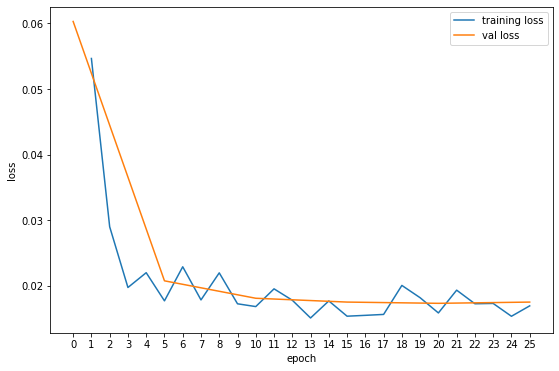

In [ ]:
# plot loss on train and dev set
fig , axis = plt.subplots(1,1,figsize = (9,6))
axis.plot(np.array(range(1,len(loss)+1)),loss,label="training loss")
axis.plot(np.array(range(1,len(val_loss)+1)),val_loss,label="val loss")
axis.legend()
#plt.xticks(np.array(range(len(loss)+1)))
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title('Loss on dev set')
plt.show()
fig.savefig('loss.png')

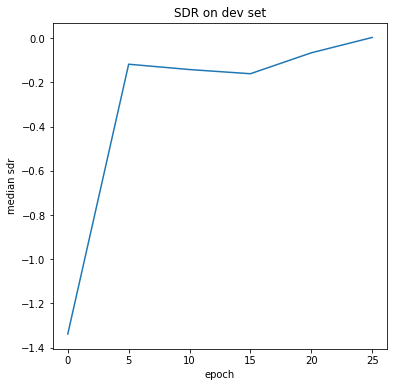

In [ ]:
# plot sdr on dev set
fig , axis = plt.subplots(1,1,figsize = (6,6))
axis.plot(np.array(range(len(val_sdr))), val_sdr, label = "median sdr on val set")
plt.xlabel('epoch')
plt.ylabel('median sdr')
plt.title('SDR on dev set')
plt.show()
fig.savefig('sdr.png')

### Test set metrics

In [ ]:
dataset = 'test'

In [ ]:
# load the entire dataset
input_spec = np.load(os.path.join(path[dataset],'input_spec.npy'))
input_phase = np.load(os.path.join(path[dataset],'input_phase.npy'))
output_spec = np.load(os.path.join(path[dataset],'output_spec.npy'))
output_phase = np.load(os.path.join(path[dataset],'output_phase.npy'))
dvec = np.load(os.path.join(path[dataset],'dvec.npy'))

In [ ]:
# re construct target waves using output spectrogram and output phase
target_waves = []
for i in tqdm(range(output_spec.shape[0])):
  target_waves.append(audio.spec2wave(output_spec[i], output_phase[i]))

100%|██████████| 934/934 [00:25<00:00, 37.24it/s]


In [ ]:
def compute_loss_sdr_test(weights_path):
  model.load_weights(weights_path)
  predict_spec = model.predict(x={'input_spec':input_spec,'dvec':dvec} , batch_size = batch_size, verbose = 1)
  test_loss = np.mean(np.square(output_spec - predict_spec))
  sdr=[]
  for i in tqdm(range(predict_spec.shape[0])):
    predict_wave = audio.spec2wave(predict_spec[i], input_phase[i])
    sdr.append(bss_eval_sources(target_waves[i], predict_wave, False)[0][0])
  test_sdr = np.median(np.array(sdr))
  return test_loss, test_sdr

In [ ]:
weights_path = os.path.join(dataset_path,'Model weights','weights_epoch0025.h5')
print("")
print("loss, sdr : ",end="")
print(compute_loss_sdr_test(weights_path))

117/117 [==============================] - 103s 881ms/step


100%|██████████| 934/934 [01:40<00:00,  9.26it/s]


[0.015660254, 0.015660254]
[1.1376163677233428, 1.1376163677233428]


### Test audio samples

In [ ]:
## preprocess audio in the same way as training audio input
def preprocess_audio(audio_path):
  wave,_ = librosa.load(audio_path,sr=hyper_params.sample_rate) 
  wave,_ = librosa.effects.trim(wave, top_db=20)  #trim silent portions
  length_wave = int(hyper_params.sample_rate * hyper_params.data_audio_len) 
  if(wave.shape[0]<length_wave) :
    return
  wave = wave[:length_wave] #clip wave to a fixed wavelength
  norm = np.max(np.abs(wave)) * 1.1 #normalize
  wave = wave/norm
  return wave

In [ ]:
## pass input spec and dvec thru model and re construct wave after combining with input phase
def get_filtered_wave(input_spec_path, phase_path, dvec_path):
  input_spec = np.load(input_spec_path)
  phase = np.load(phase_path)
  dvec = np.load(dvec_path)
  dvec = np.expand_dims(dvec,axis=0)
  input_spec = np.expand_dims(input_spec,axis=0)
  clean_spec = model.predict(x={ 'input_spec' : input_spec, 'dvec' : dvec}, verbose=1)
  wave = audio.spec2wave(clean_spec[0],phase)
  return np.asarray(wave)

In [ ]:
from IPython.display import Audio as ipythonAudio
import pandas as pd
import numpy as np
import librosa
import random

In [ ]:
#workflow to test model on random audio speech
#hyper_params = HyperParams()
#audio = Audio(hyper_params)
#wave = pre_process_audio(<audio path>)
#spec = None
#phase = None
#if wave is not None: 
#  spec, phase = audio.wave2spec(wave)
#clean_wave = store_audio_from_spec(spec , phase, <dvector path>)
#if clean_wave is not None:
#  librosa.output.write_wav('<some file name>.flac', clean_wave , sr=hyper_params.sample_rate)

In [ ]:
dataset_audio = 'train'
df = pd.read_csv(os.path.join(path[dataset_audio],'data_frame.csv'))
print(df)

         key  ...                                       dvector_path
0          2  ...  drive/My Drive/LibriSpeech Dataset/LibriSpeech...
1          3  ...  drive/My Drive/LibriSpeech Dataset/LibriSpeech...
2          4  ...  drive/My Drive/LibriSpeech Dataset/LibriSpeech...
3          5  ...  drive/My Drive/LibriSpeech Dataset/LibriSpeech...
4          6  ...  drive/My Drive/LibriSpeech Dataset/LibriSpeech...
...      ...  ...                                                ...
29346  62247  ...  drive/My Drive/LibriSpeech Dataset/LibriSpeech...
29347  62248  ...  drive/My Drive/LibriSpeech Dataset/LibriSpeech...
29348  62498  ...  drive/My Drive/LibriSpeech Dataset/LibriSpeech...
29349  62499  ...  drive/My Drive/LibriSpeech Dataset/LibriSpeech...
29350  62750  ...  drive/My Drive/LibriSpeech Dataset/LibriSpeech...

[29351 rows x 9 columns]


In [ ]:
idx = random.choice(range(df.shape[0]))
print(idx)

22288


In [ ]:
# ref speech used for d vector
ref_wave,_ = librosa.load(df['ref_speech'][idx],sr=hyper_params.sample_rate)
print(df['ref_speech'][idx])
ipythonAudio(ref_wave, rate = hyper_params.sample_rate)

drive/My Drive/LibriSpeech Dataset/LibriSpeech Train Dataset/train-clean-100/8238/274553/8238-274553-0042.flac


In [ ]:
# primary speech
pri_wave,_ = librosa.load(df['pri_speech'][idx],sr=hyper_params.sample_rate)
print(df['pri_speech'][idx])
ipythonAudio(pri_wave, rate = hyper_params.sample_rate)

drive/My Drive/LibriSpeech Dataset/LibriSpeech Train Dataset/train-clean-100/8238/274553/8238-274553-0047.flac


In [ ]:
# secondary speech
sec_wave,_ = librosa.load(df['sec_speech'][idx],sr=hyper_params.sample_rate)
print(df['sec_speech'][idx])
ipythonAudio(sec_wave, rate = hyper_params.sample_rate)

drive/My Drive/LibriSpeech Dataset/LibriSpeech Train Dataset/train-clean-100/8630/305213/8630-305213-0054.flac


In [ ]:
noisy_spec_path = df['input_spec_path'][idx]
output_spec_path = df['output_spec_path'][idx]
input_phase_path = df['input_phase_path'][idx]
output_phase_path = df['output_phase_path'][idx]
dvector_path = df['dvector_path'][idx]
noisy_spec = np.load(noisy_spec_path)
input_phase = np.load(input_phase_path)

In [ ]:
# mixed audio input
noisy_wave = audio.spec2wave( noisy_spec, input_phase )
ipythonAudio(noisy_wave, rate = hyper_params.sample_rate)

In [ ]:
# filtered audio from model
#filtered_wave = get_filtered_wave( noisy_spec_path, input_phase_path, dvector_path )
#ipythonAudio(filtered_wave, rate = hyper_params.sample_rate)

In [ ]:
# ideal target wave
target_wave = audio.spec2wave( np.load(output_spec_path), np.load(output_phase_path))
ipythonAudio(target_wave, rate = hyper_params.sample_rate)

In [ ]:
librosa.output.write_wav('noise.flac', noisy_wave , sr=hyper_params.sample_rate)
librosa.output.write_wav('clean.flac', filtered_wave , sr=hyper_params.sample_rate)